March Madness 2017 Predictions


Part of the beauty of the model is in its simplicity, taking only scoring margin and home and away as features. As such, there is only some filtering (to 2017), name changing, and light feature creation to be done on the training set. Inspired from Alex Kaechele

In [3]:
# Load needed packages
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import random

# Import data
dat = pd.read_csv("./input/RegularSeasonDetailedResults.csv") 
team_key = pd.read_csv("./input/Teams.csv")[["Team_Id", "Team_Name"]]

# Filter to 2019
dat = dat[dat.Season == 2017].reset_index(drop = True)

# Make home
dat['homei'] = np.where(dat.Wloc == "H", 1, 0)
dat['homej'] = np.where(dat.Wloc == "A", 1, 0)

# Create margin
dat['margin'] = dat.Wscore - dat.Lscore

# Filter to needed columns and rename
dat = dat[["Season", "Daynum", "Wteam", "Wscore", "Lteam", "Lscore", "margin", "homei", "homej"]]
dat = dat.rename(columns={'Wteam' : 'teami',
                          'Wscore'  : 'scorei', 
                          'Lteam' : 'teamj', 
                          'Lscore'  : 'scorej',
                          'Daynum'  : 'daynum',
                          'Season'  : 'season'})

# Create a game id
dat["gameid"] = np.where(dat['teami'] < dat['teamj'], 
                         dat['teami'].astype(str) + "_" + dat['teamj'].astype(str), 
                         dat['teamj'].astype(str) + "_" + dat['teami'].astype(str))

# Set up team id mapping
team_key["id"] = range(1, len(team_key.index) + 1)

# Recoding ids to be between 1 and 366
dat = dat.merge(team_key, left_on="teami" , right_on="Team_Id")
dat = dat.drop(columns=["Team_Name", "teami", "Team_Id"])
dat = dat.rename(index = str, columns = {"id" : "teami"})
dat = dat.merge(team_key, left_on="teamj" , right_on="Team_Id")
dat = dat.drop(columns=["Team_Name", "teamj", "Team_Id"])
dat = dat.rename(index = str, columns = {"id" : "teamj"})

# Final dataset for modeling
names = ["N", "y", "h_i", "h_j", "team_i", "team_j", "N_g"]
values = [len(dat.index), dat.margin, dat.homei, dat.homej, dat.teami, dat.teamj, 366]

train = dict(zip(names, values))



Bad key "text.kerning_factor" on line 4 in
/Users/salih/anaconda3/envs/March/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Building the Model

Here the model is trained on the 2017 regular season results:

In [7]:
model = """
data {
    int N;
    vector[N] y;
    int team_i[N];
    int team_j[N];
    int h_i[N];
    int h_j[N];
    int N_g;
}
parameters {
    vector[N_g] alpha_raw;
    vector[N_g] theta_raw;
    real eta;
    real<lower=0> tau_theta;
    real<lower=0> tau_alpha;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N_g] alpha;
    vector[N_g] theta;
    alpha = eta + alpha_raw*tau_alpha;
    theta = theta_raw*tau_theta;
}
model {
    // vector for conditional mean storage
    vector[N] mu;

    // priors
    tau_theta ~ cauchy(0,1)T[0,];
    tau_alpha ~ cauchy(0,.25)T[0,];
    sigma ~ cauchy(0,1)T[0,];
    eta ~ normal(4,1);
    theta_raw ~ normal(0,1);
    alpha_raw ~ normal(0,1);

    // define mu for the Gaussian
    for( t in 1:N ) {
    mu[t] = (theta[team_i[t]] + alpha[team_i[t]]*h_i[t]) - 
    (theta[team_j[t]] + alpha[team_j[t]]*h_j[t]);
}

    // the likelihood
    y ~ normal(mu,sigma);
}
"""



sm = pystan.StanModel(model_code = model)
fit = sm.sampling(data = train, 
                  iter = 1500, 
                  warmup = 750,
                  refresh = 100,
                  control = dict(adapt_delta = 0.9))


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa965bddd3ff659f18d82172fce2b1d5 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Model Visualizations

Let's take a look at who the teams to beat are according to the model. Here are boxplots of the top 25 team's skill, sorted by their median values. One criticism of this model is that it doesn't adjust for strength of schedule. Gonzaga, Nevada, and NC State might not be ranked as highly taking SoS into consideration.

Text(0, 0.5, 'Teams')

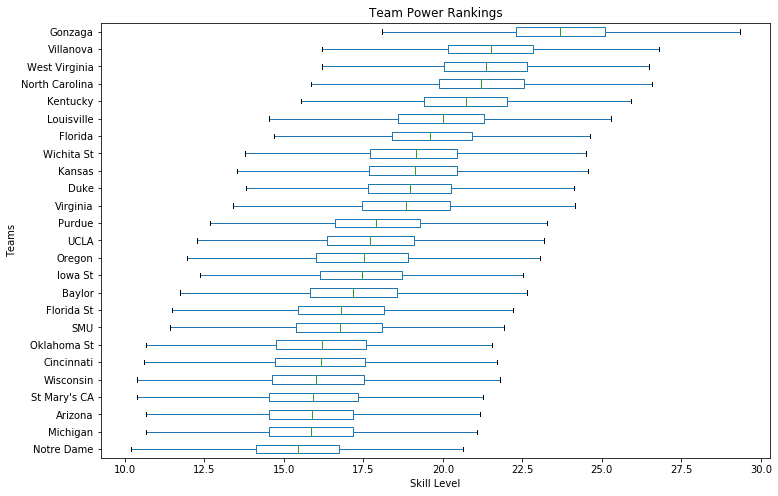

In [8]:
# Extracting team skill levels
theta = pd.DataFrame(fit.extract()["theta"])
alpha = pd.DataFrame(fit.extract()["alpha"])
sigma = fit.extract()["sigma"]
alpha.columns = team_key.Team_Name
theta.columns = team_key.Team_Name

# Filtering to top 25 teams
theta25 = theta[theta.median().nlargest(25).index]
theta25 = theta25[theta25.columns[::-1]]

# Creating the plot
theta25.boxplot(grid = False, vert = False, showfliers = False, figsize=(12, 8))
plt.title('Team Power Rankings')
plt.xlabel('Skill Level')
plt.ylabel('Teams')

## How it Works

In this model, we estimate the skill level of each team based on the point differential of their games in the season, adjusting for home court advantage. In this example, we match KU and K-State up against each other. KU has a higher estimated skill level, so their density plot is further to the right. 

To calculate the win percentage, we make draws based on these distributions, and find the percentage of games each team won over 1000 hypothetical games. You can see the sample game for KU as the blue vertical line and K-State as the purple vertical line.

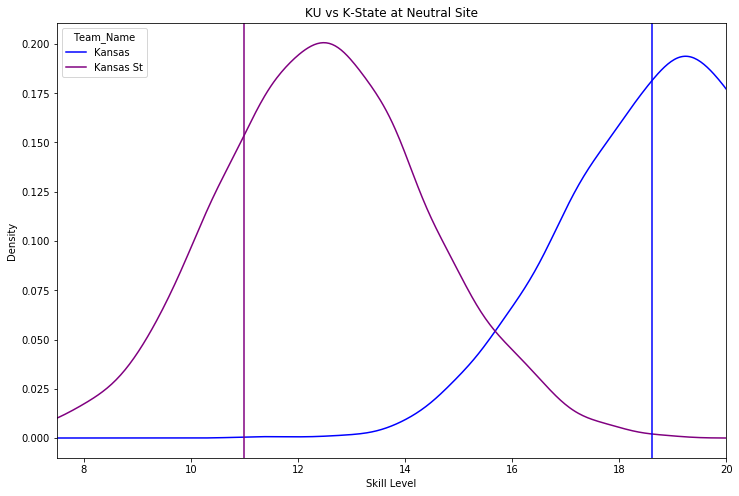

In [9]:
# Setting up seed for reproducability
random.seed(6)

# Making the skill density plots for Kansas vs Kansas St
theta[["Kansas" , "Kansas St"]].plot(kind='density', 
                                     color = ["blue", "purple"], 
                                     figsize=(12, 8))
plt.title('KU vs K-State at Neutral Site')
plt.xlabel('Skill Level')
plt.xlim([7.5, 20])

# Doing one game draw
plt.axvline(theta["Kansas"][random.randrange(len(theta["Kansas"]))], color = "blue")
plt.axvline(theta["Kansas St"][random.randrange(len(theta["Kansas St"]))], color = "purple")


Now, for our final model we added home court advantage. Let's see how the skill distributions change if K-State is playing at home.

We can see that K-State's home court advantage is greater than the skill difference, giving them the edge in the matchup.

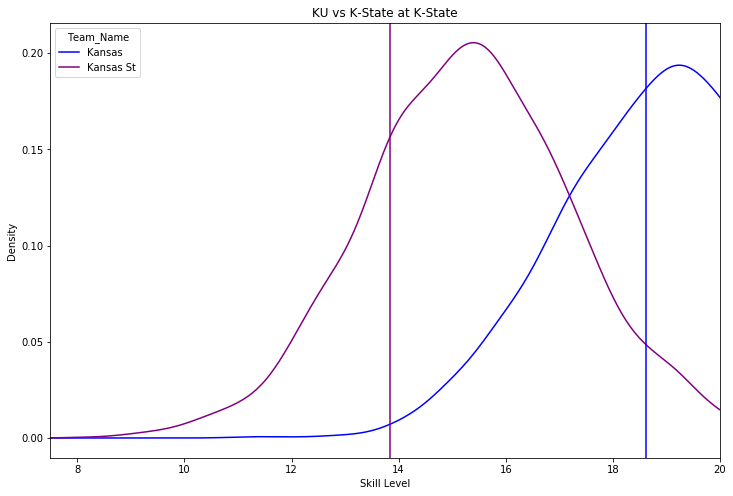

In [10]:
# Setting up seed for reproducability
random.seed(6)

# Setting up a home court adjusted dataset for Kstate
# Promise the actual function is more elegant
ftheta = theta.copy()
ftheta["Kansas St"] = ftheta["Kansas St"] + alpha["Kansas St"]

# Making the skill density plots for Kansas vs Kansas St
ftheta[["Kansas" , "Kansas St"]].plot(kind='density', 
                                     color = ["blue", "purple"],
                                     figsize=(12, 8))
plt.title('KU vs K-State at K-State')
plt.xlabel('Skill Level')
plt.xlim([7.5, 20])

# Doing one game draw
plt.axvline(ftheta["Kansas"][random.randrange(len(ftheta["Kansas"]))], color = "blue")
plt.axvline(ftheta["Kansas St"][random.randrange(len(ftheta["Kansas St"]))], color = "purple")


## Predictions

Now time to make the predictions for the tournament. According to our model, Virginia had about a two thirds chance of winning the title. Although, the model also doesn't take in to account Virginia skating by to the finals and Texas Tech's recent good form.

In [11]:
# Setting seed
random.seed(1865)

# Defining compare function
def compare(i, j, th= theta, a = alpha, sig = sigma, homei = 0, homej = 0, reps = 1000):
    win_prob = []
    
    # Simulating specified number of games
    for r in range(1, reps):
        win_prob.append(
            np.mean(
                
                # Ability difference
                th[i] - th[j] +
                
                # Adjusting for home court
                a[i]*homei - a[j]*homej +
                
                # Team performance variance
                np.random.normal(0, 
                                 sig[random.randrange(len(sig))], 
                                 len(th.index)
                ) > 0
            )
        )
    
    # Averaging game results
    win_prob = np.mean(win_prob)
    
    # Displaying results
    print(i + " has a " + str(round(win_prob*100, 2)) + "% chance of beating " + j)
    
# Looking at final game
compare("North Carolina", "Gonzaga")

North Carolina has a 40.91% chance of beating Gonzaga


## Prediction Evaluation

No prediction is worth much without exploring how your prediction matched up against the competition. 

Against Industry Experts**

To compare to some of the industry, we put our methods to the test against [FiveThirtyEight's March Madness Predictions](https://projects.fivethirtyeight.com/2017-march-madness-predictions/). Even with their slight edge at being able to adjust their models to take into account performance within the tournament, our model did slightly better.

In [31]:
# Getting table of games played
games = pd.DataFrame(np.array([['Play in',  "Kansas St", "Wake Forest",   0, 0, .68],
                               ['Play in',  "Mt St Mary's",  "New Orleans",    0, 1, .53],
                               ['Play in',  "UC Davis", "NC Central", 0, 0, .55],
                               ['Play in',  "Southern Univ",     "Providence",       0, 0, .58],
                               
                               ['Rd 64',    "Duke",           "Troy",     1, 0, 1.0], 
                               ['Rd 64',    "Virginia",       "UNC Wilmington",    0, 0, .98], 
                               ['Rd 64',    "Gonzaga",        "South Dakota",     1, 0, .99], 
                               ['Rd 64',    "North Carolina", "TX Southern",            0, 0, .98], 
                               ['Rd 64',    "Michigan St",    "Miami FL",         0, 0, .96], 
                               ['Rd 64',    "Kentucky",       "Northern Iowa",     1, 0, .97], 
                               ['Rd 64',    "Arizona",      "North Dakota",         0, 0, .95], 
                               ['Rd 64',    "Michigan",       "Oklahoma",         1, 0, .94], 
                               ['Rd 64',    "South Carolina",     "Marquette",      0, 0, .91], 
                               ['Rd 64',    "Purdue",         "Vermont",    0, 0, .88], 
                               ['Rd 64',    "Wisconsin",      "Virginia Tech",        0, 1, .89], 
                               ['Rd 64',    "Southern Univ",         "SMU",   0, 1, .77], 
                               ['Rd 64',    "Florida",        "ETSU",          0, 0, .42], 
                               ['Rd 64',    "St Mary's CA",     "Vermont",         0, 1, .79], 
                               ['Rd 64',    "Florida St",        "FL Gulf Coast",         0, 0, .33], 
                               ['Rd 64',    "Villanova",      "Mt St Mary's",    1, 0, .75], 
                               ['Rd 64',    "Xavier",            "Maryland",            0, 0, .84], 
                               ['Rd 64',    "West Virginia",       "Bucknell",     0, 0, .53], 
                               ['Rd 64',    "Notre Dame",         "Princeton",       1, 0, .40], 
                               ['Rd 64',    "Northwestern",      "Vanderbilt",       1, 0, .23], 
                               ['Rd 64',    "MTSU",           "Minnesota",      0, 0, .32], 
                               ['Rd 64',    "Butler",     "Winthrop",         0, 1, .49], 
                               ['Rd 64',    "Arkansas",         "Seton Hall",    1, 0, .83], 
                               ['Rd 64',    "Cincinnati",        "Kansas St",      0, 0, .89], 
                               ['Rd 64',    "UCLA",        "Kent",      0, 0, .63], 
                               ['Rd 64',    "Wichita St",        "Dayton",      0, 0, .66], 
                               ['Rd 64',    "Kansas",      "UC Davis",       0, 0, .36], 
                               ['Rd 64',    "Iowa St",         "Nevada",        1, 0, .40], 
                               ['Rd 64',    "Rhode Island",      "Creighton",      0, 0, .32], 
                               ['Rd 64',    "Oregon",       "Iona",         0, 0, .62], 
                               ['Rd 64',    "Louisville",            "Jacksonville St", 0, 0, .50], 
                               ['Rd 64',    "Baylor",        "New Mexico St",  0, 0, .21], 
                               
                               ['Rd 32',    "South Carolina",           "Duke",        0, 0, .91], 
                               ['Rd 32',    "Baylor",  "Southern Univ",    0, 0, .86], 
                               ['Rd 32',    "Wisconsin",            "Villanova",   0, 0, .56], 
                               ['Rd 32',    "Kansas",     "Michigan St", 0, 0, .83], 
                               ['Rd 32',    "Gonzaga",        "Northwestern",     0, 0, .91], 
                               ['Rd 32',    "Florida",     "Virginia",  0, 0, .70], 
                               ['Rd 32',    "Butler",     "MTSU",    1, 0, .67], 
                               ['Rd 32',    "Michigan",       "Louisville",    1, 0, .76], 
                               ['Rd 32',    "North Carolina", "Arkansas", 1, 0, .87], 
                               ['Rd 32',    "UCLA",         "Cincinnati",     0, 1, .56], 
                               ['Rd 32',    "Kentucky",        "Wichita St",    0, 0, .72], 
                               ['Rd 32',    "Arizona",       "St Mary's CA",    0, 0, .72], 
                               ['Rd 32',    "Xavier",      "Florida St",       0, 0, .80], 
                               ['Rd 32',    "Purdue",         "Iowa St",  0, 0, .53], 
                               ['Rd 32',    "Oregon",         "Rhode Island",  0, 0, .69], 
                               ['Rd 32',    "West Virginia",       "Notre Dame",   0, 0, .88], 
                               
                               ["Sweet 16", "Xavier",        "Arizona",  0, 0, .75],
                               ["Sweet 16", "South Carolina", "Baylor",            0, 0, .74],
                               ["Sweet 16", "Gonzaga",     "West Virginia",     1, 0, .74],
                               ["Sweet 16", "Florida",  "Wisconsin",       1, 0, .51],
                               ["Sweet 16", "North Carolina",      "Butler", 0, 0, .38],
                               ["Sweet 16", "Kentucky",    "UCLA",        0, 0, .56],
                               ["Sweet 16", "Oregon",      "Michigan",      0, 0, .49],
                               ["Sweet 16", "Kansas",    "Purdue",         1, 0, .87],
                               
                               ["Elite 8",  "Oregon",      "Kansas", 0, 0, .37],
                               ["Elite 8",  "South Carolina", "Florida",     0, 0, .33],
                               ["Elite 8",  "Gonzaga",    "Xavier",   0, 0, .64],
                               ["Elite 8",  "North Carolina",  "Kentucky",  0, 0, .37],
                               
                               ["Final 4",  "Gonzaga", "South Carolina", 0, 0, .46],
                               ["Final 4",  "North Carolina",   "Oregon",      0, 0, .73]]),
                               columns = ['Round', 'Winner', 'Loser', 'Winhome', 'Losehome', 'FiveThirtyEight'])

# Defining new compare function
def compare2(i, j, th= theta, a = alpha, sig = sigma, homei = 0, homej = 0, reps = 1000):
    win_prob = []
    
    # Simulating specified number of games
    for r in range(1, reps):
        win_prob.append(
            np.mean(
                
                # Ability difference
                th[i] - th[j] +
                
                # Adjusting for home court
                a[i]*homei - a[j]*homej +
                
                # Team performance variance
                np.random.normal(0, 
                                 sig[random.randrange(len(sig))], 
                                 len(th.index)
                ) > 0
            )
        )
    
    # Averaging game results
    win_prob = np.mean(win_prob)
    
    return(win_prob)
    
preds = []

for g in range(len(games.index)):
    preds.append(compare2(games["Winner"][g], 
                          games["Loser"][g], 
                          homei = int(games["Winhome"][g]), 
                          homej = int(games["Losehome"][g])))
games["ours"] = preds

print("Our Mean Absolute Error is " + str(round(1 - np.mean(games["ours"]), 5)))
print("FiveThirtyEight's Mean Absolute Error is " + str(round(1 - np.mean(pd.to_numeric(games["FiveThirtyEight"])), 5)))


Our Mean Absolute Error is 0.34238
FiveThirtyEight's Mean Absolute Error is 0.33348


# See All Our Predicted Results

Just in case you wanted to see all our prediction results, I included them below. The "ours" column gives our predicted chances of the eventual winner.

In [32]:
pd.set_option('display.max_rows', 500)
games[["Round", "Winner", "Loser", "FiveThirtyEight", "ours"]]

,Round,Winner,Loser,FiveThirtyEight,ours
0,Play in,Kansas St,Wake Forest,0.68,0.507625
1,Play in,Mt St Mary's,New Orleans,0.53,0.370198
2,Play in,UC Davis,NC Central,0.55,0.352975
3,Play in,Southern Univ,Providence,0.58,0.037983
4,Rd 64,Duke,Troy,1.0,0.972829
5,Rd 64,Virginia,UNC Wilmington,0.98,0.823575
6,Rd 64,Gonzaga,South Dakota,0.99,0.991426
7,Rd 64,North Carolina,TX Southern,0.98,0.985686
8,Rd 64,Michigan St,Miami FL,0.96,0.421013
9,Rd 64,Kentucky,Northern Iowa,0.97,0.986321
